In [ ]:
from google.colab import files
files.upload() #подключение через json file


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"meruwert","key":"cf56d3dc5001f7bcecbeebbb47726234"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download chethuhn/network-intrusion-dataset
#скачивание датасета

Dataset URL: https://www.kaggle.com/datasets/chethuhn/network-intrusion-dataset
License(s): CC0-1.0
 97% 223M/230M [00:00<00:00, 652MB/s] 
100% 230M/230M [00:00<00:00, 677MB/s]


In [ ]:
!unzip network-intrusion-dataset.zip -d ./dataset
#распака датасета

Archive:  network-intrusion-dataset.zip
  inflating: ./dataset/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv  
  inflating: ./dataset/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv  
  inflating: ./dataset/Friday-WorkingHours-Morning.pcap_ISCX.csv  
  inflating: ./dataset/Monday-WorkingHours.pcap_ISCX.csv  
  inflating: ./dataset/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv  
  inflating: ./dataset/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv  
  inflating: ./dataset/Tuesday-WorkingHours.pcap_ISCX.csv  
  inflating: ./dataset/Wednesday-workingHours.pcap_ISCX.csv  


In [ ]:
path = 'dataset'

In [ ]:
import os
print(os.listdir(path))

['Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv', 'Wednesday-workingHours.pcap_ISCX.csv', 'Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv', 'Friday-WorkingHours-Morning.pcap_ISCX.csv', 'Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv', 'Tuesday-WorkingHours.pcap_ISCX.csv', 'Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv', 'Monday-WorkingHours.pcap_ISCX.csv']


In [ ]:
import os
import pandas as pd
import numpy as np
import hashlib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, ConfusionMatrixDisplay
)
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

def string2numeric_hash(text: str) -> int:
    return int(hashlib.md5(text.encode()).hexdigest()[:8], 16)

def train_test(X, y, test_size: float):
    return train_test_split(X, y, test_size=test_size, random_state=42)

def normalize_data(X_train, X_test):
    from sklearn.preprocessing import StandardScaler, MinMaxScaler
    import joblib

    scaler = MinMaxScaler(feature_range=(-1, 1)).fit(X_train)
    joblib.dump(scaler, 'scaler.pkl')  # ✅ Сохраняем scaler

    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test


def test_normal_atk(y_true, y_pred):
    df = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
    normal = (df.y_true == 0).sum()
    atk    = (df.y_true == 1).sum()
    wrong  = df[df.y_true != df.y_pred]
    counts = wrong.y_true.value_counts().to_dict()
    wn = counts.get(0, 0)
    wa = counts.get(1, 0)
    return ((normal - wn) / normal if normal else 0,
            (atk    - wa) / atk    if atk    else 0)

In [ ]:
path     = 'dataset'
csv_file = 'Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv'
csv_path = os.path.join(path, csv_file)

data = pd.read_csv(csv_path)

#Стрипаем пробелы в названиях колонок
data.columns = [c.strip().replace(' ', '_') for c in data.columns]

#Приводим NaN в числовых столбцах к нулю
data.replace(['Infinity', np.inf, -np.inf], 0, inplace=True)
for col in ['Flow_Packets/s', 'Flow_Bytes/s']:
    if col in data.columns:
        data[col] = pd.to_numeric(data[col], errors='coerce').fillna(0)

# Преобразуем Label:BENIGN → 0; любая строка, содержащая 'ddos' → 1; остальное (если есть) — 0
data['Label'] = np.where(
    data['Label'].str.lower().str.contains('ddos'),
    1,
    0
)

#Хэшируем Timestamp
if 'Timestamp' in data.columns:
    data['Timestamp'] = data['Timestamp'].fillna('1970-01-01 00:00:00')
    data['Timestamp'] = data['Timestamp'].apply(string2numeric_hash)

#Удаляем все IP, порт и ID поля
drop_cols = [c for c in data.columns if c.lower().endswith(('ip','port','id'))]
data.drop(columns=drop_cols, errors='ignore', inplace=True)

print(f"Форма данных после preprocessing: {data.shape}")
print("Распределение классов:\n", data['Label'].value_counts())


Форма данных после preprocessing: (225745, 78)
Распределение классов:
 Label
1    128027
0     97718
Name: count, dtype: int64


In [ ]:
normal = data[data['Label'] == 0]
ddos   = data[data['Label'] == 1]

if len(ddos) == 0:
    raise RuntimeError("Не найдено строк с DDoS-метками — проверьте preprocessing.")

normal_up = resample(
    normal,
    replace=True,
    n_samples=len(ddos),
    random_state=27
)
balanced_df = pd.concat([normal_up, ddos], ignore_index=True)
print("Баланс после ресемплинга:\n", balanced_df['Label'].value_counts())

Баланс после ресемплинга:
 Label
0    128027
1    128027
Name: count, dtype: int64


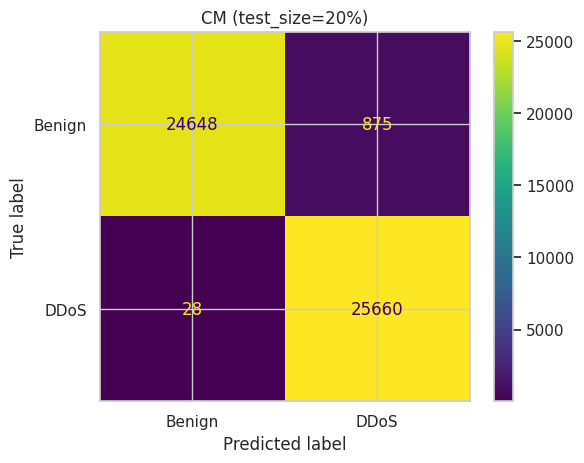

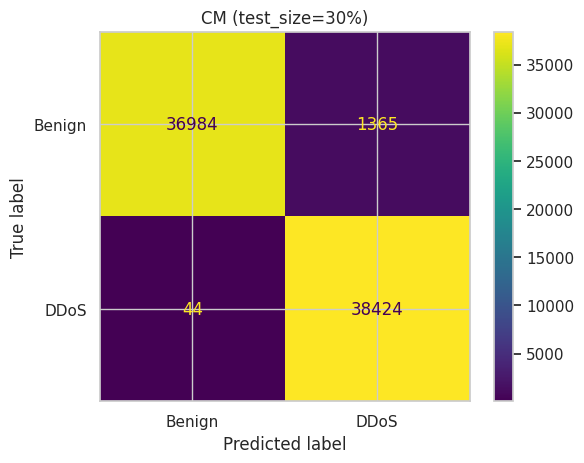

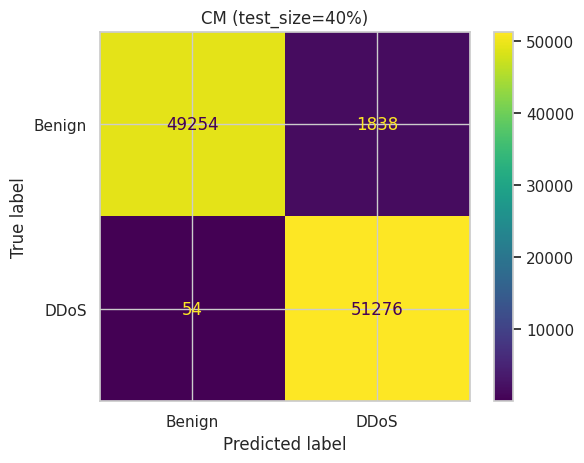

In [ ]:
results = []
for test_size in [0.2, 0.3, 0.4]:
    X = balanced_df.drop(columns=['Label'])
    y = balanced_df['Label']
    X_tr, X_te, y_tr, y_te = train_test(X, y, test_size=test_size)
    X_tr, X_te = normalize_data(X_tr, X_te)

    model = SVC(kernel='linear', random_state=42)
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)

    acc, prec, rec, f1 = (
        accuracy_score(y_te, y_pred),
        precision_score(y_te, y_pred),
        recall_score(y_te, y_pred),
        f1_score(y_te, y_pred)
    )
    nd, ad = test_normal_atk(y_te, y_pred)

    #Матрица ошибок
    ConfusionMatrixDisplay.from_predictions(
        y_te, y_pred, display_labels=['Benign','DDoS']
    )
    plt.title(f'CM (test_size={int(test_size*100)}%)')
    plt.show()

    results.append({
        'TestSize': test_size,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1_Score': f1,
        'Normal_Detect_Rate': nd,
        'Atk_Detect_Rate': ad
    })

Результаты обучения SVM на разных разбиениях:
   TestSize  Accuracy  Precision    Recall  F1_Score  Normal_Detect_Rate  \
0       0.2  0.982367   0.967025  0.998910  0.982709            0.965717   
1       0.3  0.981658   0.965694  0.998856  0.981995            0.964406   
2       0.4  0.981527   0.965395  0.998948  0.981885            0.964026   

   Atk_Detect_Rate  
0         0.998910  
1         0.998856  
2         0.998948  


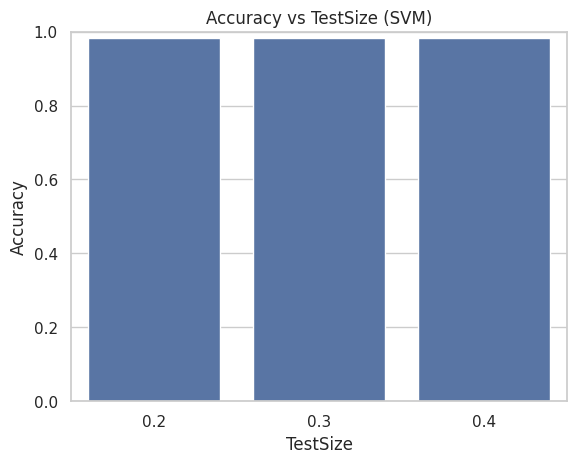

In [ ]:
results_df = pd.DataFrame(results).sort_values('Accuracy', ascending=False).reset_index(drop=True)
print("Результаты обучения SVM на разных разбиениях:")
print(results_df)

sns.barplot(data=results_df, x='TestSize', y='Accuracy')
plt.ylim(0, 1)
plt.title('Accuracy vs TestSize (SVM)')
plt.show()